Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
from glob import glob

In [ ]:
## mounting the google drive
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Drive Files/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Drive Files/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [ ]:
## getting a count of the images in the training and test sets
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [ ]:
## Defining the training dataset using tf.keras.preprocessing.image_dataset_from_directory
## seed=123 
## resizing the images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
 data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
## Defining the validation dataset using tf.keras.preprocessing.image_dataset_from_directory
## seed=123 
## resizing the images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
# Listing out all the classes of skin cancer and storing them in a list. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data

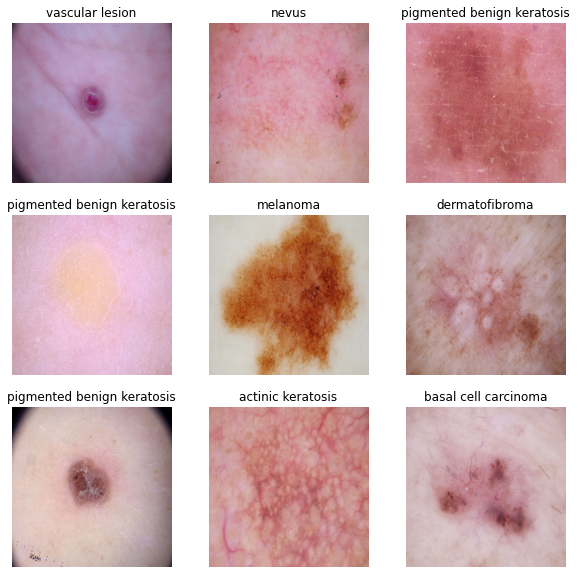

In [ ]:
# creating a code to visualize one instance of all the nine classes present in the dataset
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8")) 
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

In [ ]:
## keeping the datasset in the memory
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Model Creation
#### Creating a CNN model, which can accurately detect 9 classes present in the dataset. Using ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
### Creating the base CNN model
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255,offset=0, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Model Compilation

In [ ]:
### choosing an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

### Model Training

In [ ]:
## training the model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 370s 1s/step - loss: 2.0172 - accuracy: 0.2567 - val_loss: 1.8506 - val_accuracy: 0.2953
Epoch 2/20
56/56 [==============================] - 2s 43ms/step - loss: 1.6945 - accuracy: 0.3783 - val_loss: 1.5788 - val_accuracy: 0.4027
Epoch 3/20
56/56 [==============================] - 2s 41ms/step - loss: 1.5323 - accuracy: 0.4598 - val_loss: 1.5203 - val_accuracy: 0.5190
Epoch 4/20
56/56 [==============================] - 2s 41ms/step - loss: 1.3935 - accuracy: 0.5179 - val_loss: 1.4384 - val_accuracy: 0.4855
Epoch 5/20
56/56 [==============================] - 2s 41ms/step - loss: 1.3152 - accuracy: 0.5352 - val_loss: 1.3345 - val_accuracy: 0.5481
Epoch 6/20
56/56 [==============================] - 2s 41ms/step - loss: 1.2272 - accuracy: 0.5664 - val_loss: 1.3532 - val_accuracy: 0.5548
Epoch 7/20
56/56 [==============================] - 2s 41ms/step - loss: 1.1361 - accuracy: 0.6016 - val_loss: 1.4991 - val_accuracy: 0.5168
Epoch 8/20
56

### Visualizing training results

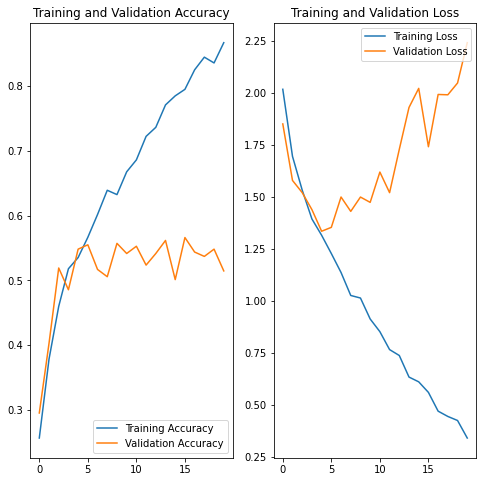

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings from above figures
- There is a huge mismatch between the training and the validation accuracy.
- The plots above also show an almost linear trend in the training accuracy with epochs but the validation accuracy is fluctuating around the 50% mark.
- These obsservations clearly indicate towards overfitting!

In [ ]:
# choosing an appropriate data augumentation strategy 
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

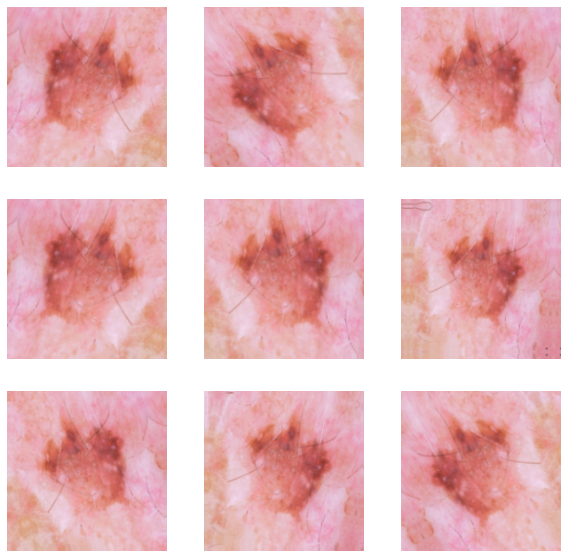

In [ ]:
# visualizing how the augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Create the model, compile and train the model


In [ ]:
## using dropout layer
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


### Compiling the model

In [ ]:

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [ ]:
## training the model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 4s 51ms/step - loss: 2.1241 - accuracy: 0.2506 - val_loss: 1.8636 - val_accuracy: 0.3199
Epoch 2/20
56/56 [==============================] - 3s 46ms/step - loss: 1.7998 - accuracy: 0.3454 - val_loss: 1.6762 - val_accuracy: 0.4116
Epoch 3/20
56/56 [==============================] - 3s 46ms/step - loss: 1.6166 - accuracy: 0.4291 - val_loss: 1.4765 - val_accuracy: 0.4787
Epoch 4/20
56/56 [==============================] - 3s 47ms/step - loss: 1.4825 - accuracy: 0.4766 - val_loss: 1.5338 - val_accuracy: 0.4541
Epoch 5/20
56/56 [==============================] - 3s 46ms/step - loss: 1.4750 - accuracy: 0.4860 - val_loss: 1.4881 - val_accuracy: 0.4877
Epoch 6/20
56/56 [==============================] - 3s 46ms/step - loss: 1.3741 - accuracy: 0.5140 - val_loss: 1.4141 - val_accuracy: 0.5123
Epoch 7/20
56/56 [==============================] - 3s 46ms/step - loss: 1.4383 - accuracy: 0.4989 - val_loss: 1.4934 - val_accuracy: 0.4586
Epoch 8/20
56

### Visualizing the results

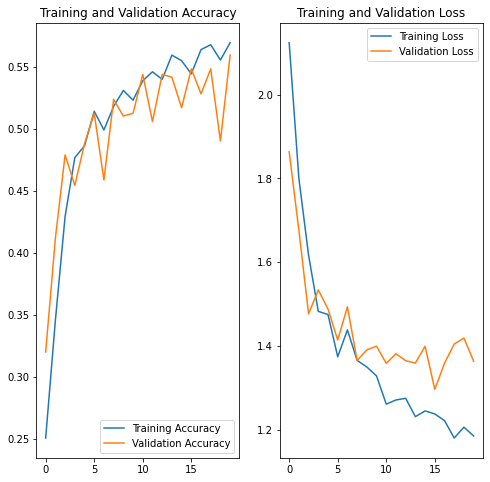

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Findings:
- The training and the validation accuracies are close to each other.
- The graph above also shows a close correspondence between the training and the validation accuracies.
- The problem of overfitting has been solved but both the accuracies are now in the lower ranges.
- There could be class imbalances which are hampering the model performance. 


#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
## Your code goes here.

### Creating orignal_df to visualize the class imbalance

In [ ]:
## defining a path dictionary
path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))}

In [ ]:
## checking out how the paths look
print(path_dict)

{'ISIC_0026626': '/content/gdrive/MyDrive/Drive Files/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/ISIC_0026626.jpg', 'ISIC_0027668': '/content/gdrive/MyDrive/Drive Files/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/ISIC_0027668.jpg', 'ISIC_0028941': '/content/gdrive/MyDrive/Drive Files/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/ISIC_0028941.jpg', 'ISIC_0029900': '/content/gdrive/MyDrive/Drive Files/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0029900.jpg', 'ISIC_0027254': '/content/gdrive/MyDrive/Drive Files/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/ISIC_0027254.jpg', 'ISIC_0030142': '/content/gdrive/MyDrive/Drive Files/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0030142.jpg', 'ISIC_0027896': '/content/gdrive/MyDrive/Drive Files/Skin cancer ISIC The International Skin Imagin

In [ ]:
## creating a list from the dictionary
a = list(path_dict.items())

In [ ]:
## defining the path_list
path_list = list(map(lambda x: x[1], a))

In [ ]:
## defining the labels list
labels_list = [i.split('/')[-2] for i in path_list]

In [ ]:
## creating the orignal_df
orignal_df = pd.DataFrame(list(dict(zip(path_list, labels_list)).items()),columns = ['Path','Label'])
orignal_df.head()

,Path,Label
0,/content/gdrive/MyDrive/Drive Files/Skin cance...,nevus
1,/content/gdrive/MyDrive/Drive Files/Skin cance...,nevus
2,/content/gdrive/MyDrive/Drive Files/Skin cance...,nevus
3,/content/gdrive/MyDrive/Drive Files/Skin cance...,actinic keratosis
4,/content/gdrive/MyDrive/Drive Files/Skin cance...,nevus


In [ ]:
## checking the value couhts of the different labels
orignal_df['Label'].value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
dermatofibroma                 95
actinic keratosis              52
seborrheic keratosis            2
Name: Label, dtype: int64

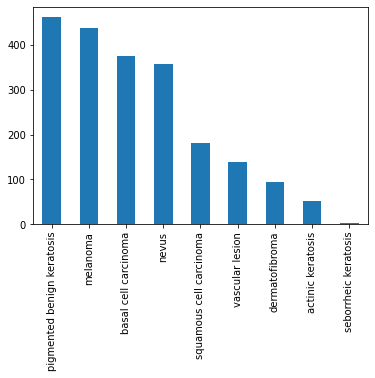

In [ ]:
## visualizing the value counts
orignal_df['Label'].value_counts().plot(kind='bar')
plt.show()


#### - Which class has the least number of samples?
         - "seborrheic keratosis"
#### - Which classes dominate the data in terms proportionate number of samples?
          - "pigmented benign keratosis'



#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
## installing Augmentor
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
## pipeline for actinic keratosis
import Augmentor
p = Augmentor.Pipeline('/content/gdrive/MyDrive/Drive Files/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis')
p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
p.sample(500)

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F15059DFAD0>:   0%|          | 1/500 [00:00<00:55,  8.97 Samples/s]

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Drive Files/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F15059FA690>: 100%|██████████| 500/500 [00:22<00:00, 22.70 Samples/s]


In [ ]:
## pipeline for basal cell carcinoma
p = Augmentor.Pipeline('/content/gdrive/MyDrive/Drive Files/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma')
p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
p.sample(500)


Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Drive Files/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1506CA4DD0>: 100%|██████████| 500/500 [00:22<00:00, 22.37 Samples/s]


In [ ]:
## pipeline for dermatofibroma
p = Augmentor.Pipeline('/content/gdrive/MyDrive/Drive Files/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma')
p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
p.sample(500)

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F15059FA8D0>:   0%|          | 1/500 [00:00<01:26,  5.75 Samples/s]

Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Drive Files/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1506CA4F50>: 100%|██████████| 500/500 [00:22<00:00, 22.56 Samples/s]


In [ ]:
## pipeline for melanoma
p = Augmentor.Pipeline('/content/gdrive/MyDrive/Drive Files/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma')
p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
p.sample(500)


Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Drive Files/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F1501E00B90>: 100%|██████████| 500/500 [01:36<00:00,  5.20 Samples/s]


In [ ]:
## pipeline for nevus
p = Augmentor.Pipeline('/content/gdrive/MyDrive/Drive Files/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus')
p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
p.sample(500)


Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Drive Files/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7F15027A1150>: 100%|██████████| 500/500 [01:36<00:00,  5.17 Samples/s]


In [ ]:
## pipeline for pigmented benign keratosis
p = Augmentor.Pipeline('/content/gdrive/MyDrive/Drive Files/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis')
p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
p.sample(500)


Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Drive Files/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1501E5B510>: 100%|██████████| 500/500 [00:22<00:00, 21.92 Samples/s]


In [ ]:
## pipeline for seborrheic keratosis
p = Augmentor.Pipeline('/content/gdrive/MyDrive/Drive Files/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis')
p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
p.sample(500)


Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Drive Files/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F1501F5F250>: 100%|██████████| 500/500 [00:49<00:00, 10.17 Samples/s]


In [ ]:
## pipeline for squamous cell carcinoma
p = Augmentor.Pipeline('/content/gdrive/MyDrive/Drive Files/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma')
p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
p.sample(500)

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F1501E8E150>:   0%|          | 1/500 [00:00<01:02,  7.96 Samples/s]

Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Drive Files/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1506C9FBD0>: 100%|██████████| 500/500 [00:22<00:00, 22.02 Samples/s]


In [ ]:
## pipeline for vascular lesion
p = Augmentor.Pipeline('/content/gdrive/MyDrive/Drive Files/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion')
p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
p.sample(500)


Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Drive Files/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F15ADA95510>: 100%|██████████| 500/500 [00:23<00:00, 21.59 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
## checking the count of the images created by Augmentor
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
## creating the new path list
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/MyDrive/Drive Files/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033705.jpg_20ad2511-b2ee-4105-9889-d1e2544dc90f.jpg',
 '/content/gdrive/MyDrive/Drive Files/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027668.jpg_c3bcd427-4898-47ed-a6e0-1d1f917082ad.jpg',
 '/content/gdrive/MyDrive/Drive Files/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029713.jpg_0a014ef9-f317-453a-ac3f-1954e72be5d2.jpg',
 '/content/gdrive/MyDrive/Drive Files/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027958.jpg_00322fd9-d6da-4a88-a21b-ca96f9585e06.jpg',
 '/content/gdrive/MyDrive/Drive Files/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/outp

In [ ]:
## Creating the new lesion list
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [ ]:
## creating a dictionary by zipping the two lists
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [ ]:
## creating new_df
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = orignal_df.append(df2)

In [ ]:
## checking the value counts in the new_df
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
dermatofibroma                595
actinic keratosis             552
seborrheic keratosis          502
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [ ]:
## defing the parameters
batch_size = 32
img_height = 180
img_width = 180

####Create a training dataset

In [ ]:
## remounting the drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
## Defining the training dataset using tf.keras.preprocessing.image_dataset_from_directory
## seed=123 
## resizing the images to the size img_height*img_width, while writting the dataset
data_dir_train="/content/gdrive/MyDrive/Drive Files/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [ ]:
## Defining the validation dataset using tf.keras.preprocessing.image_dataset_from_directory
## seed=123 
## resizing the images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset ='validation', ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Create your model (make sure to include normalization)

In [ ]:
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255,offset=0, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

#### Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
## compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

####  Train your model

In [ ]:
## training for 30 epochs
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 46s 264ms/step - loss: 2.4607 - accuracy: 0.2583 - val_loss: 2.1597 - val_accuracy: 0.1166
Epoch 2/30
169/169 [==============================] - 44s 253ms/step - loss: 1.5238 - accuracy: 0.4238 - val_loss: 2.1961 - val_accuracy: 0.2717
Epoch 3/30
169/169 [==============================] - 44s 252ms/step - loss: 1.3398 - accuracy: 0.4781 - val_loss: 1.5199 - val_accuracy: 0.4581
Epoch 4/30
169/169 [==============================] - 43s 250ms/step - loss: 1.2025 - accuracy: 0.5395 - val_loss: 1.3805 - val_accuracy: 0.5063
Epoch 5/30
169/169 [==============================] - 44s 254ms/step - loss: 1.0515 - accuracy: 0.5885 - val_loss: 1.7973 - val_accuracy: 0.4588
Epoch 6/30
169/169 [==============================] - 44s 253ms/step - loss: 0.9499 - accuracy: 0.6274 - val_loss: 1.1662 - val_accuracy: 0.5865
Epoch 7/30
169/169 [==============================] - 45s 258ms/step - loss: 0.8442 - accuracy: 0.6734 - val_loss: 1.3388 - val_ac

####  Visualize the model results

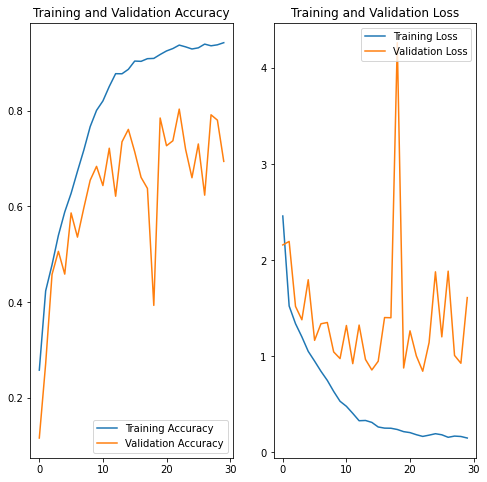

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?
- The results indicate some overfitting tendency in the model still exists.
- The class rebalance did help though, in reducing the gap between the training and the validation datasets. This gap was earlier in the range of about 40% and now it has come down to about 20% after class rebalance. 
- Given the limited resoures in terms of computing horsepower and time, this model is somewhat satisfactory.

